Device info: UnitInfo(driver=<picosdk.ps2000.Ps2000lib object at 0x7f0ab4439d90>, variant=b'2205A', serial=b'EY451/364')


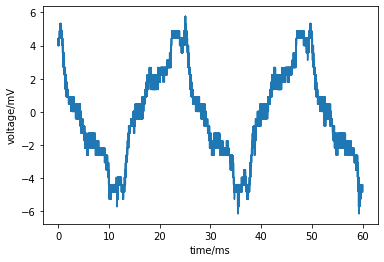

In [1]:
from ctypes import POINTER, c_int16, c_uint32

import matplotlib.pyplot as plt
import numpy as np

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok
from picosdk.PicoDeviceEnums import picoEnum
from picosdk.ctypes_wrapper import C_CALLBACK_FUNCTION_FACTORY

import time

CALLBACK = C_CALLBACK_FUNCTION_FACTORY(
    None,
    POINTER(POINTER(c_int16)),
    c_int16,
    c_uint32,
    c_int16,
    c_int16,
    c_uint32
)

adc_values = []


def get_overview_buffers(buffers, _overflow, _triggered_at, _triggered, _auto_stop, n_values):
    adc_values.extend(buffers[0][0:n_values])


callback = CALLBACK(get_overview_buffers)


def adc_to_mv(values, range_, bitness=16):
    v_ranges = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000]

    return [(x * v_ranges[range_]) / (2**(bitness - 1) - 1) for x in values]


with ps2000.open_unit() as device:
    print('Device info: {}'.format(device.info))

    res = ps2000.ps2000_set_channel(
        device.handle,
        picoEnum.PICO_CHANNEL['PICO_CHANNEL_A'],
        True,
        picoEnum.PICO_COUPLING['PICO_DC'],
        ps2000.PS2000_VOLTAGE_RANGE['PS2000_50MV'],
    )
    assert_pico2000_ok(res)

    res = ps2000.ps2000_run_streaming_ns(
        device.handle,
        500,
        2,
        100_000,
        False,
        1,
        50_000
    )
    assert_pico2000_ok(res)

    start_time = time.time_ns()

    while time.time_ns() - start_time < 60_000_000:
        ps2000.ps2000_get_streaming_last_values(
            device.handle,
            callback
        )

    end_time = time.time_ns()

    ps2000.ps2000_stop(device.handle)

    mv_values = adc_to_mv(adc_values, ps2000.PS2000_VOLTAGE_RANGE['PS2000_50MV'])

    fig, ax = plt.subplots()

    ax.set_xlabel('time/ms')
    ax.set_ylabel('voltage/mV')
    ax.plot(np.linspace(0, (end_time - start_time) * 1e-6, len(mv_values)), mv_values)

    plt.show()

Values gathered: 6000206


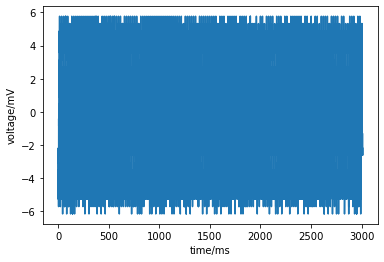

In [2]:
from time import time_ns
from ctypes import POINTER, c_int16, c_uint32

import matplotlib.pyplot as plt
import numpy as np

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok
from picosdk.ctypes_wrapper import C_CALLBACK_FUNCTION_FACTORY

from enum import IntEnum


class Channel(IntEnum):
    PS2000_CHANNEL_A = 0
    PS2000_CHANNEL_B = 1


class PotentialRange(IntEnum):
    PS2000_10MV = 0
    PS2000_20MV = 1
    PS2000_50MV = 2
    PS2000_100MV = 3
    PS2000_200MV = 4
    PS2000_500MV = 5
    PS2000_1V = 6
    PS2000_2V = 7
    PS2000_5V = 8
    PS2000_10V = 9
    PS2000_20V = 10


class TimeUnit(IntEnum):
    FEMTOSECOND = 0
    PICOSECOND = 1
    NANOSECOND = 2
    MICROSECOND = 3
    MILLISECOND = 4
    SECOND = 5


CALLBACK = C_CALLBACK_FUNCTION_FACTORY(None, POINTER(POINTER(c_int16)), c_int16, c_uint32, c_int16, c_int16, c_uint32)


# reimplement this because the other one only takes ctypes
def adc_to_mv(values, range_, bitness=16):
    v_ranges = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000]

    return [(x * v_ranges[range_]) / (2**(bitness - 1) - 1) for x in values]


def determine_time_unit(interval_ns):
    unit = 0
    units = ['ns', 'us', 'ms', 's']

    while interval_ns > 5_000:
        interval_ns /= 1000
        unit += 1

    return interval_ns, units[unit]


class StreamingDevice:
    def __init__(self, gather_values, potential_range=PotentialRange.PS2000_50MV):
        self.device = ps2000.open_unit()
        self.potential_range = potential_range

        self.gather_values = gather_values

        res = ps2000.ps2000_set_channel(self.device.handle, Channel.PS2000_CHANNEL_A, True, True, potential_range)
        assert_pico2000_ok(res)

        # start 'fast-streaming' mode
        res = ps2000.ps2000_run_streaming_ns(
            self.device.handle,
            500,
            TimeUnit.NANOSECOND,
            100_000,
            False,
            1,
            50_000
        )
        assert_pico2000_ok(res)

        self.start_time = time_ns()
        self.end_time = time_ns()

    def close(self):
        ps2000.ps2000_stop(self.device.handle)
        self.device.close()

    def gather(self):
        adc_values = []

        def get_overview_buffers(buffers, _overflow, _triggered_at, _triggered, _auto_stop, n_values):
            adc_values.extend(buffers[0][0:n_values])

        callback = CALLBACK(get_overview_buffers)

        while len(adc_values) < self.gather_values:
            ps2000.ps2000_get_streaming_last_values(
                self.device.handle,
                callback
            )

        self.end_time = time_ns()

        return adc_to_mv(adc_values, self.potential_range)


stream = StreamingDevice(6_000_000)
values = stream.gather()
stream.close()

print('Values gathered: {}'.format(len(values)))

fig, ax = plt.subplots()
interval, units = determine_time_unit(stream.end_time - stream.start_time)

ax.set_xlabel('time/{}'.format(units))
ax.set_ylabel('voltage/mV')
ax.plot(np.linspace(0, interval, len(values)), values)

plt.show()

In [1]:
not working

import asyncio
import concurrent.futures
import functools

from ctypes import POINTER, c_int16, c_uint32

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok
from picosdk.ctypes_wrapper import C_CALLBACK_FUNCTION_FACTORY

from enum import IntEnum


class Channel(IntEnum):
    PS2000_CHANNEL_A = 0
    PS2000_CHANNEL_B = 1


class PotentialRange(IntEnum):
    PS2000_20MV = 1
    PS2000_50MV = 2
    PS2000_100MV = 3
    PS2000_200MV = 4
    PS2000_500MV = 5
    PS2000_1V = 6
    PS2000_2V = 7
    PS2000_5V = 8
    PS2000_10V = 9
    PS2000_20V = 10


CALLBACK = C_CALLBACK_FUNCTION_FACTORY(None, POINTER(POINTER(c_int16)), c_int16, c_uint32, c_int16, c_int16, c_uint32)


# reimplement this because the other one only takes ctypes
def adc_to_mv(values, range_, bitness=16):
    v_ranges = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000]

    return [(x * v_ranges[range_]) / (2**(bitness - 1) - 1) for x in values]


class StreamingDevice:
    def __init__(self, potential_range=PotentialRange.PS2000_50MV):
        self.device = ps2000.open_unit()
        self.potential_range = potential_range
        # create an event loop
        self.loop = asyncio.new_event_loop()
        # create a thread-pool executor
        self.executor = concurrent.futures.ThreadPoolExecutor()

        self.waiting_blocks = {}

        res = ps2000.ps2000_set_channel(self.device.handle, Channel.PS2000_CHANNEL_A, True, True, potential_range)
        assert_pico2000_ok(res)

        # start 'fast-streaming' mode
        res = ps2000.ps2000_run_streaming_ns(
            self.device.handle,
            100,
            3,
            30_000,
            False,
            1,
            15_000
        )
        assert_pico2000_ok(res)

    async def process_value(self, mv_value):
        # overload
        pass

    def get_streamed_values(self, block_id):
        def get_overview_buffers(buffers, _overflow, _triggered_at, _triggered, _auto_stop, n_values):
            adc_values = buffers[0][0:n_values]

            mv_values = adc_to_mv(adc_values, self.potential_range)

            self.waiting_blocks[block_id] = mv_values

        callback = CALLBACK(get_overview_buffers)

        res = ps2000.ps2000_get_streaming_last_values(
            self.device.handle,
            callback
        )
        assert_pico2000_ok(res)

    def start(self):
        async def gather_values():
            block_id = 0
            while True:
                await asyncio.sleep(0.5)

                await self.loop.run_in_executor(self.executor, functools.partial(self.get_streamed_values, block_id))

                block_id += 1

        async def poll_waiting():
            next_block = 0
            while True:
                if block := self.waiting_blocks.get(next_block):
                    next_block += 1
                    for n in block:
                        await self.process_value(n)

                await asyncio.sleep(0.25)

        try:
            self.loop.create_task(gather_values())
            self.loop.run_until_complete(poll_waiting())
        finally:
            self.loop.close()
            ps2000.ps2000_stop(self.device.handle)
            ps2000.ps2000_close_unit(self.device.handle)


stream = StreamingDevice()
stream.start()

Task was destroyed but it is pending!
task: <Task pending name='Task-1' coro=<StreamingDevice.start.<locals>.gather_values() running at <ipython-input-1-acb1490024ee>:91>>
/home/sca-user/anaconda3/lib/python3.8/asyncio/base_events.py:641: RuntimeWarning: coroutine 'StreamingDevice.start.<locals>.gather_values' was never awaited
  self._ready.clear()


In [6]:
not working

from ctypes import POINTER, c_int16, c_uint32

from picosdk.ps2000 import ps2000
from picosdk.functions import assert_pico2000_ok
from picosdk.ctypes_wrapper import C_CALLBACK_FUNCTION_FACTORY

from enum import IntEnum
from concurrent.futures import ThreadPoolExecutor

import functools
import time
import os

CALLBACK = C_CALLBACK_FUNCTION_FACTORY(None, POINTER(POINTER(c_int16)), c_int16, c_uint32, c_int16, c_int16, c_uint32)

THREADPOOL = ThreadPoolExecutor()

past_mv_values = []

term_width = os.get_terminal_size()


def process_values(adc_values):
    mv_values = adc_to_mv(adc_values, PotentialRange.PS2000_50MV)

    for value in mv_values:
        pre = (value + 500) / 500 * term_width
        print('{}|'.format(' ' * pre))

    past_mv_values.extend(mv_values)


def get_overview_buffers(buffers, _overflow, _triggered_at, _triggered, _auto_stop, n_values):
    adc_values = buffers[0][0:n_values]

    THREADPOOL.submit(functools.partial(process_values, adc_values))


callback = CALLBACK(get_overview_buffers)


def adc_to_mv(values, range_, bitness=16):
    v_ranges = [10, 20, 50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 20_000]

    return [(x * v_ranges[range_]) / (2**(bitness - 1) - 1) for x in values]


class Channel(IntEnum):
    PS2000_CHANNEL_A = 0
    PS2000_CHANNEL_B = 1


class PotentialRange(IntEnum):
    PS2000_20MV = 1
    PS2000_50MV = 2
    PS2000_100MV = 3
    PS2000_200MV = 4
    PS2000_500MV = 5
    PS2000_1V = 6
    PS2000_2V = 7
    PS2000_5V = 8
    PS2000_10V = 9
    PS2000_20V = 10


with ps2000.open_unit() as device:
    res = ps2000.ps2000_set_channel(device.handle, Channel.PS2000_CHANNEL_A, True, True, PotentialRange.PS2000_50MV)
    assert_pico2000_ok(res)

    res = ps2000.ps2000_run_streaming_ns(
        device.handle,
        500,
        2,
        100_000,
        False,
        1,
        50_000
    )
    assert_pico2000_ok(res)

    target_samples = 1_000_000

    while True:
        ps2000.ps2000_get_streaming_last_values(
            device.handle,
            callback
        )

        time.sleep(0.01)

NameError: name 'working' is not defined